In [51]:
import numpy as np
import pandas as pd

#obtain hierarchical dataset
from datasetsforecast.hierarchical import HierarchicalData

# compute base forecast no coherent
from statsforecast.core import StatsForecast
from statsforecast.models import AutoARIMA, Naive, ETS

#obtain hierarchical reconciliation methods and evaluation
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.evaluation import HierarchicalEvaluation
from hierarchicalforecast.methods import BottomUp, TopDown, MiddleOut
from hierarchicalforecast.methods import MinTrace
from hierarchicalforecast.utils import aggregate

import matplotlib.pyplot as plt


In [52]:
df = pd.read_csv('C:\\Users\\IqraImtiaz\\OneDrive - keystonestrategy.com\\Documents\\Moderna\\IQVIA\\iqvia_zip.csv')
df['Date'] = pd.to_datetime(df['Date'])

data = df
data = data.dropna()
data = data.dropna(subset=['PROVIDER_ZIP'])
data["PROVIDER_ZIP"] = data["PROVIDER_ZIP"].astype(str).str.strip()
data = data[data['PROVIDER_ZIP'] != "\"\""]
data["PROVIDER_ZIP"] = data["PROVIDER_ZIP"].str.replace("\"","")
data = data.sort_values(by=['PROVIDER_ZIP', 'Date'])

data['zip'] = data['PROVIDER_ZIP'].astype(str).str.split('.',expand=True)[0]
data['zip'] = np.where(data['zip'].str.len()==3,'00'+data['zip'],np.where(data['zip'].str.len()==4,'0'+data['zip'],data['zip']))
data['zip3'] = data['zip'].str.slice(stop=3)
data = data[['Date','zip3','CLM_CNT']]
data = data.groupby(['zip3','Date']).sum()

# filter on xip codes that have at least 10 data points
data = data.groupby('zip3').filter(lambda x: len(x)>10)
data.reset_index(inplace=True)

grouped_sum = data.groupby('Date')['CLM_CNT'].transform('sum')
data['natl_admins'] = grouped_sum
data['shares'] = (data['CLM_CNT'] / data['natl_admins'])
df = data

In [53]:
# Create a complete set of all possible combinations of zip3 and dates
all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='W-FRI')
all_zip3 = df['zip3'].unique()
complete_index = pd.MultiIndex.from_product([all_zip3, all_dates], names=['zip3', 'Date'])

# Reindex the DataFrame to include all combinations, filling missing values with zeros
df_complete = df.set_index(['zip3', 'Date']).reindex(complete_index, fill_value=0).reset_index()

# Prepare the data for forecasting
base_df = df_complete[['zip3', 'Date', 'CLM_CNT']].rename(columns={'zip3': 'zip3', 'Date': 'ds', 'CLM_CNT': 'y'})

In [54]:
spec = [
    ['zip3']
]

In [55]:

Y_df, S_df, tags = aggregate(base_df, spec)
Y_df = Y_df.reset_index()

In [56]:
Y_test_df = Y_df.groupby('unique_id').tail(8)
Y_train_df = Y_df.drop(Y_test_df.index)

Y_test_df = Y_test_df.set_index('unique_id')
Y_train_df = Y_train_df.set_index('unique_id')

Y_train_df.groupby('unique_id').size()

unique_id
006    100
007    100
008    100
009    100
010    100
      ... 
995    100
996    100
997    100
998    100
999    100
Length: 888, dtype: int64

In [57]:
fcst = StatsForecast(df=Y_train_df, 
                     models=[ETS(season_length=7, model='ZZA')], 
                     freq='W', n_jobs=-1)
Y_hat_df = fcst.forecast(h=8, fitted=True)
Y_fitted_df = fcst.forecast_fitted_values()


c:\Users\IqraImtiaz\.conda\envs\nixtla\lib\site-packages\statsforecast\models.py:880: FutureWarning: `ETS` will be deprecated in future versions of `StatsForecast`. Please use `AutoETS` instead.
  ETS._warn()
c:\Users\IqraImtiaz\.conda\envs\nixtla\lib\site-packages\statsforecast\core.py:474: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(
c:\Users\IqraImtiaz\.conda\envs\nixtla\lib\site-packages\statsforecast\core.py:626: FutureWarning: Passing unique_id as the index is deprecated. Please provide it as a column instead.
  warnings.warn(
c:\Users\IqraImtiaz\.conda\envs\nixtla\lib\site-packages\statsforecast\core.py:474: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will rais

In [58]:
reconcilers = [
    BottomUp(),
    MinTrace(method='mint_shrink'),
    MinTrace(method='ols')
]
hrec = HierarchicalReconciliation(reconcilers=reconcilers)
Y_rec_df = hrec.reconcile(Y_hat_df=Y_hat_df, Y_df=Y_fitted_df, S=S_df, tags=tags)


In [59]:
def rmse(y, y_hat):
    return np.mean(np.sqrt(np.mean((y-y_hat)**2, axis=1)))

def mase(y, y_hat, y_insample, seasonality=7):
    errors = np.mean(np.abs(y - y_hat), axis=1)
    scale = np.mean(np.abs(y_insample[:, seasonality:] - y_insample[:, :-seasonality]), axis=1)
    return np.mean(errors / scale)

def mape(y, y_hat):
    m = np.mean(np.abs((y - y_hat) / (y + np.finfo(float).eps)), axis=1)
    return np.mean(m * 100)

eval_tags = {}
eval_tags['zip3'] = tags['zip3']
eval_tags['All'] = np.concatenate(list(tags.values()))

evaluator = HierarchicalEvaluation(evaluators=[rmse, mase, mape])
evaluation = evaluator.evaluate(
        Y_hat_df=Y_rec_df, Y_test_df=Y_test_df,
        tags=eval_tags, Y_df=Y_train_df
)
evaluation = evaluation.drop('Overall')
evaluation.columns = ['Base', 'BottomUp', 'MinTrace(mint_shrink)', 'MinTrace(ols)']
evaluation = evaluation.applymap('{:.2f}'.format)


C:\Users\IqraImtiaz\AppData\Local\Temp\ipykernel_144\4250031310.py:22: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  evaluation = evaluation.drop('Overall')
C:\Users\IqraImtiaz\AppData\Local\Temp\ipykernel_144\4250031310.py:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  evaluation = evaluation.applymap('{:.2f}'.format)


In [60]:
evaluation

Base              BottomUp  \
level metric                                               
zip3  rmse                  499.41                499.41   
      mase                    0.49                  0.49   
      mape    46912578052406112.00  46912578052406112.00   
All   rmse                  499.41                499.41   
      mase                    0.49                  0.49   
      mape    46912578052406112.00  46912578052406112.00   

             MinTrace(mint_shrink)         MinTrace(ols)  
level metric                                              
zip3  rmse                  499.41                499.41  
      mase                    0.49                  0.49  
      mape    46912578091005832.00  46912578052406112.00  
All   rmse                  499.41                499.41  
      mase                    0.49                  0.49  
      mape    46912578091005832.00  46912578052406112.00

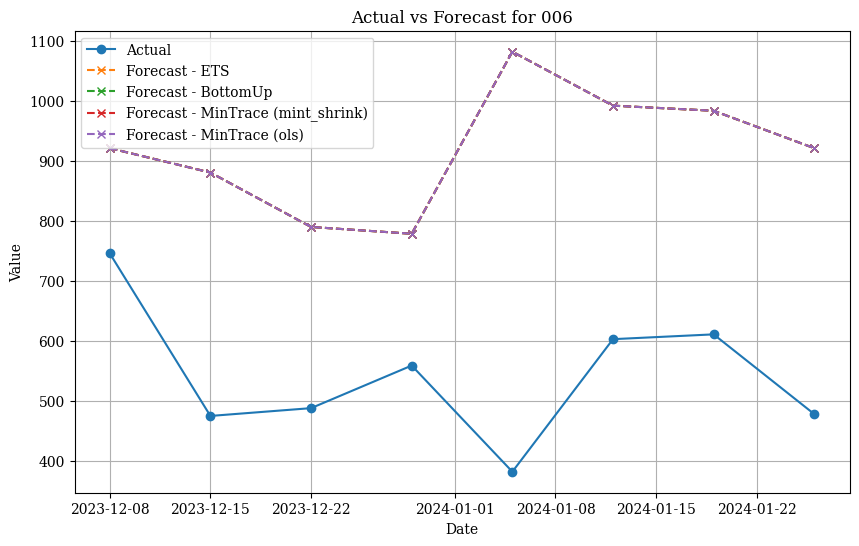

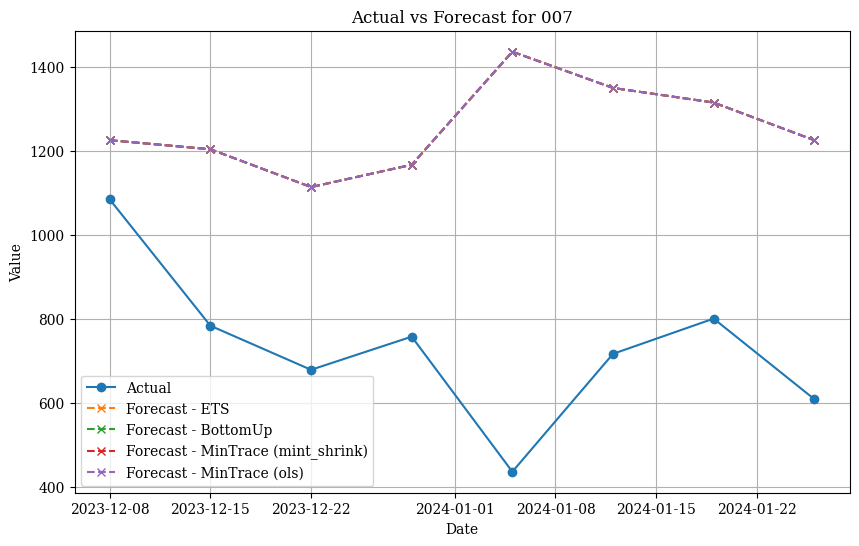

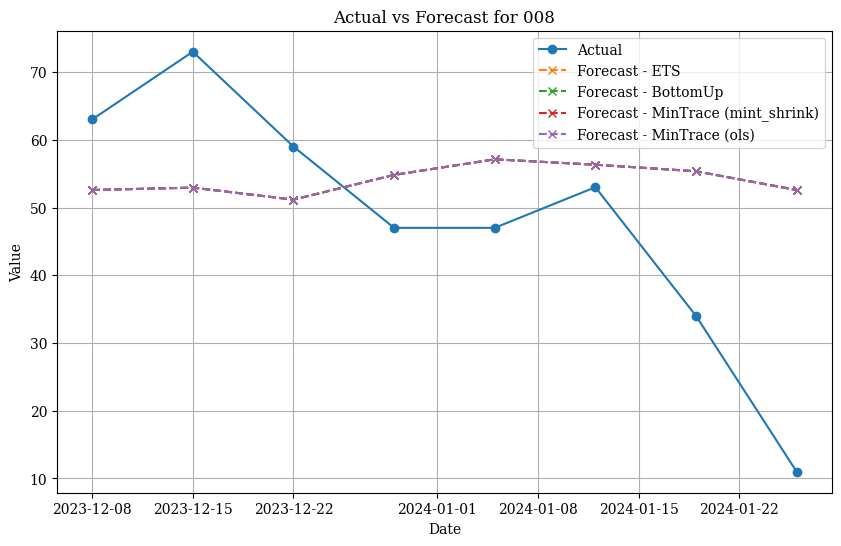

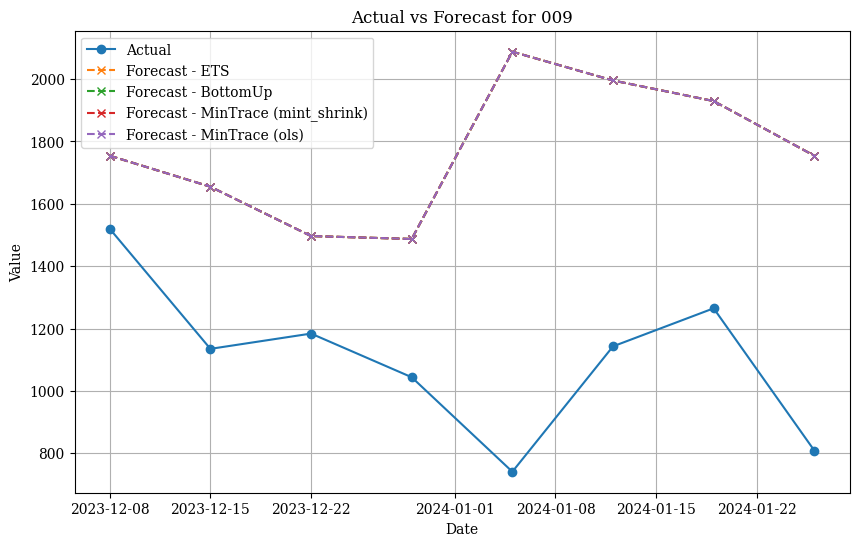

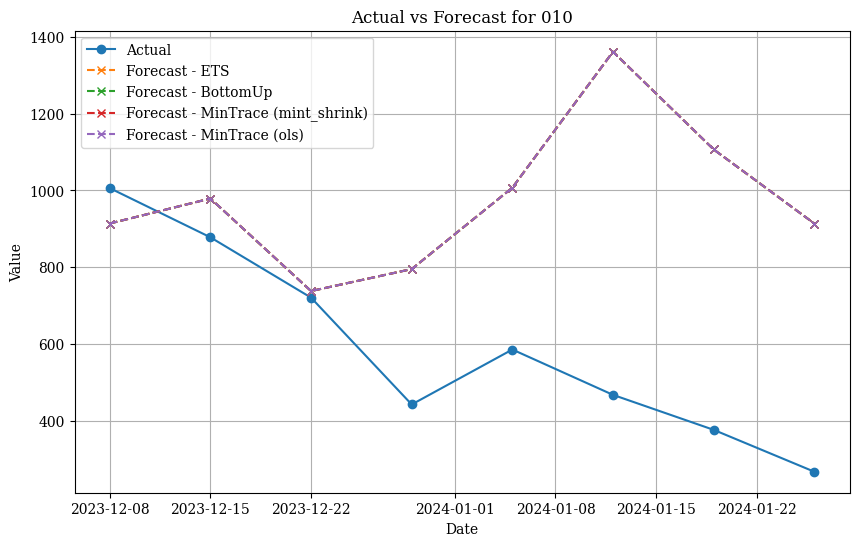

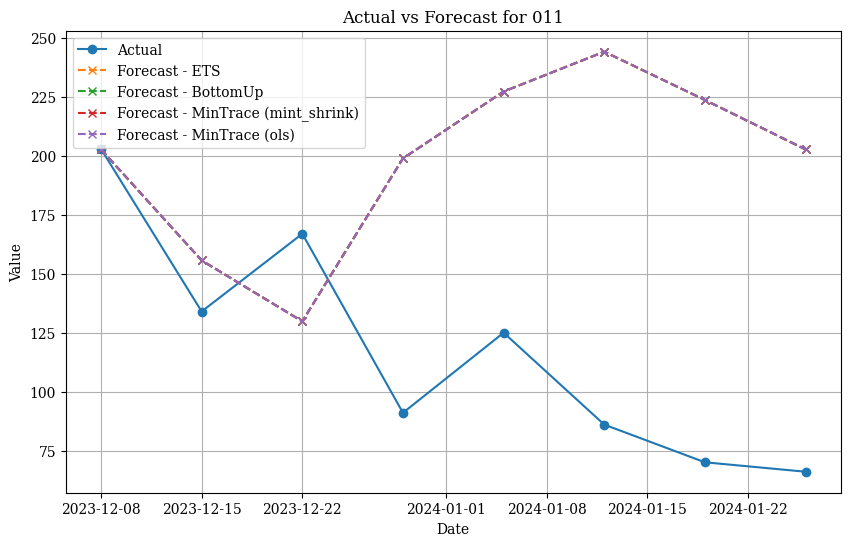

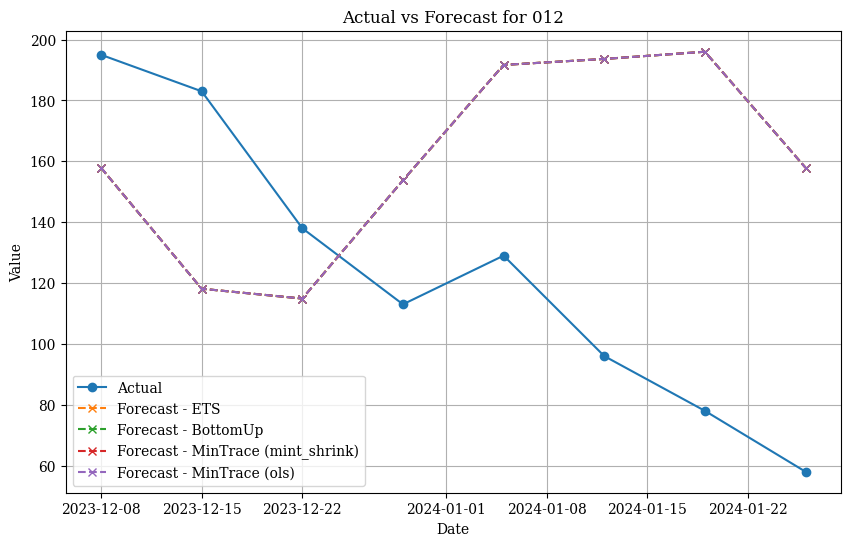

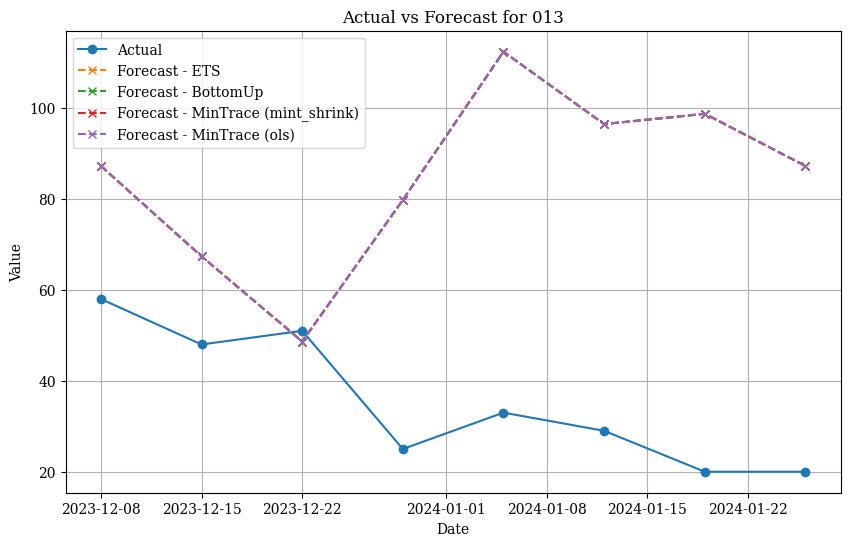

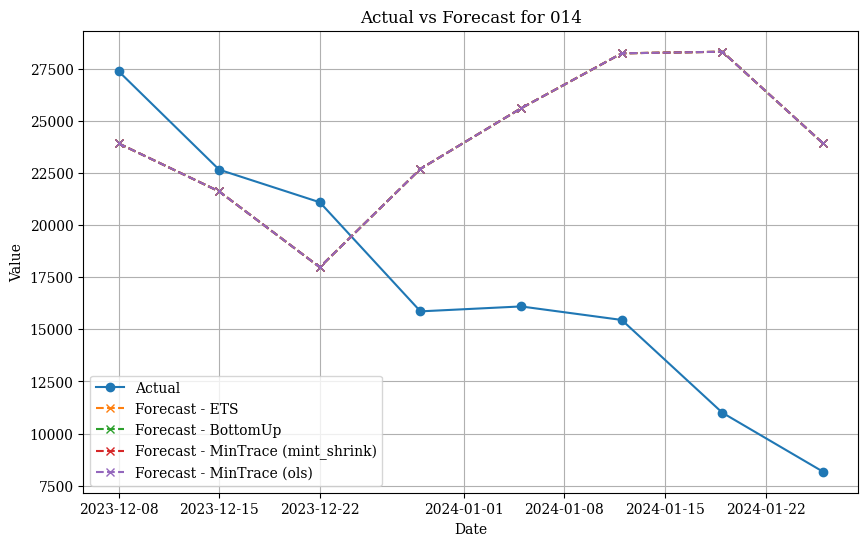

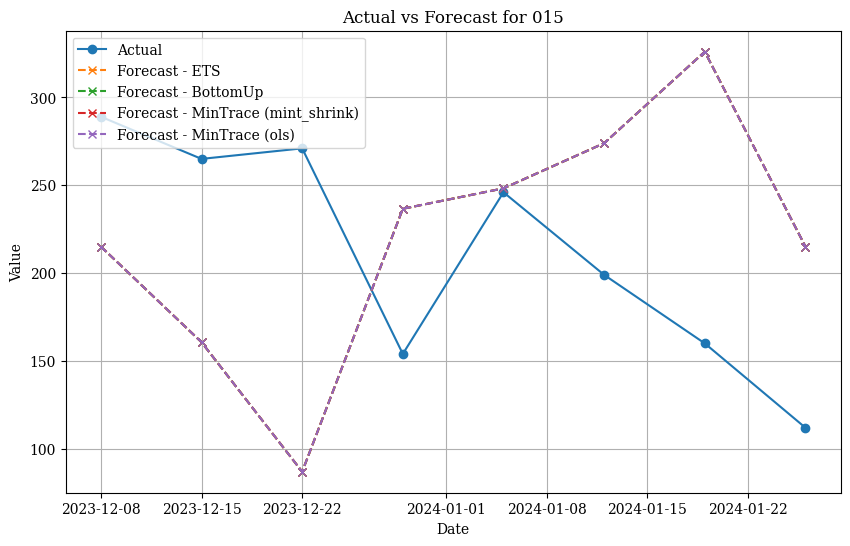

In [61]:
# Adjust the forecast dates to align with the actual test dates
# Assuming the forecasts are off by a consistent number of days (e.g., 5 days)
date_offset = (Y_test_df['ds'].iloc[0] - Y_rec_df['ds'].iloc[0]).days

# Apply the date offset correction to the forecasted dates
Y_rec_df['ds'] = Y_rec_df['ds'] + pd.Timedelta(days=date_offset)

# Now merge and plot as before
Y_test_df = Y_test_df.reset_index()
Y_rec_df = Y_rec_df.reset_index()

comparison_df = pd.merge(Y_test_df, Y_rec_df, on=['unique_id', 'ds'])

# Plotting
for unique_id in comparison_df['unique_id'].unique()[:10]:
    data = comparison_df[comparison_df['unique_id'] == unique_id]
    
    plt.figure(figsize=(10, 6))
    plt.plot(data['ds'], data['y'], label='Actual', marker='o')
    plt.plot(data['ds'], data['ETS'], label='Forecast - ETS', linestyle='--', marker='x')
    plt.plot(data['ds'], data['ETS/BottomUp'], label='Forecast - BottomUp', linestyle='--', marker='x')
    plt.plot(data['ds'], data['ETS/MinTrace_method-mint_shrink'], label='Forecast - MinTrace (mint_shrink)', linestyle='--', marker='x')
    plt.plot(data['ds'], data['ETS/MinTrace_method-ols'], label='Forecast - MinTrace (ols)', linestyle='--', marker='x')
    plt.title(f"Actual vs Forecast for {unique_id}")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()
